/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact


Performance Metrics:
                       Stock-Bond RP  Stock-Gold RP  Stock-Bond-Gold RP  \
Annualized Return           0.113339       0.101079            0.107931   
Annualized Volatility       0.115287       0.116626            0.114493   
Sharpe Ratio                0.983099       0.866695            0.942689   
Maximum Drawdown           -0.233008      -0.243049           -0.196278   
2008 Crisis                -0.060663      -0.151726           -0.048009   
2020 COVID                  0.003341      -0.028792            0.045007   
2025 Tariffs               -0.048127       0.025198            0.021201   

                       SPY (unleveraged)  SPY (leveraged)  Bonds (leveraged)  \
Annualized Return               0.117110         0.083449           0.032284   
Annualized Volatility           0.196303         0.113160           0.107247   
Sharpe Ratio                    0.596577         0.737439           0.301029   
Maximum Drawdown               -0.551894        -0.256619

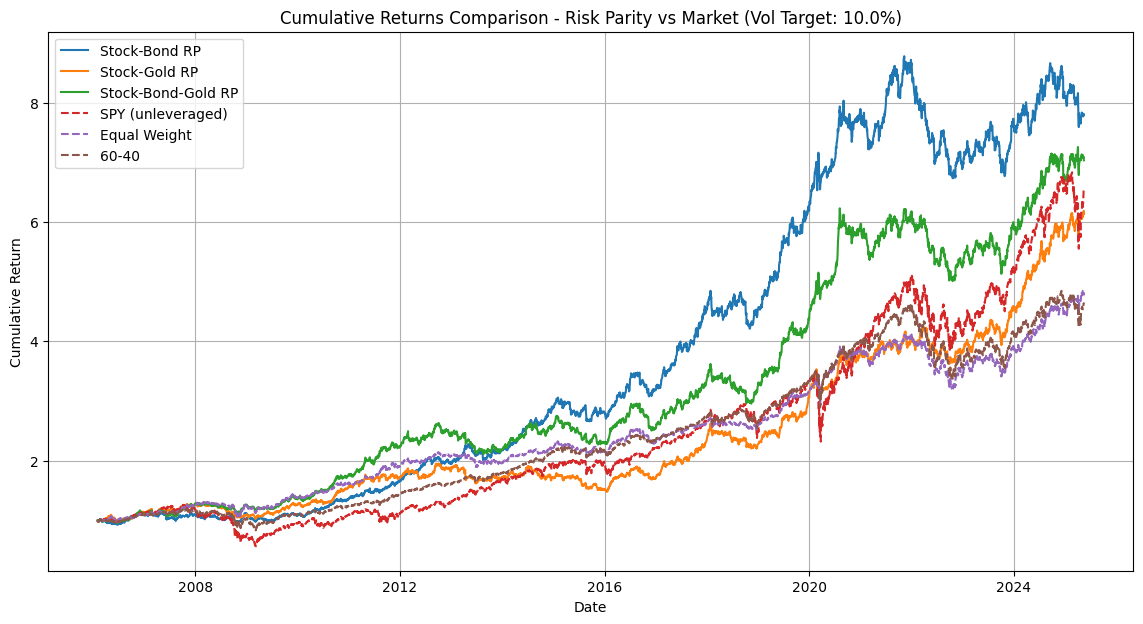

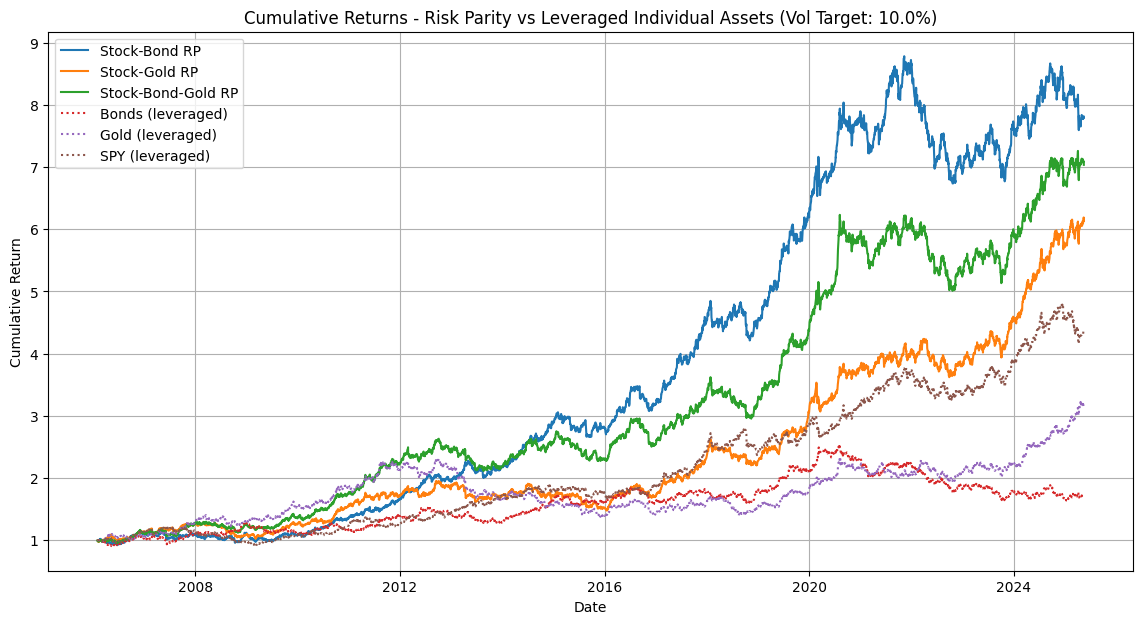

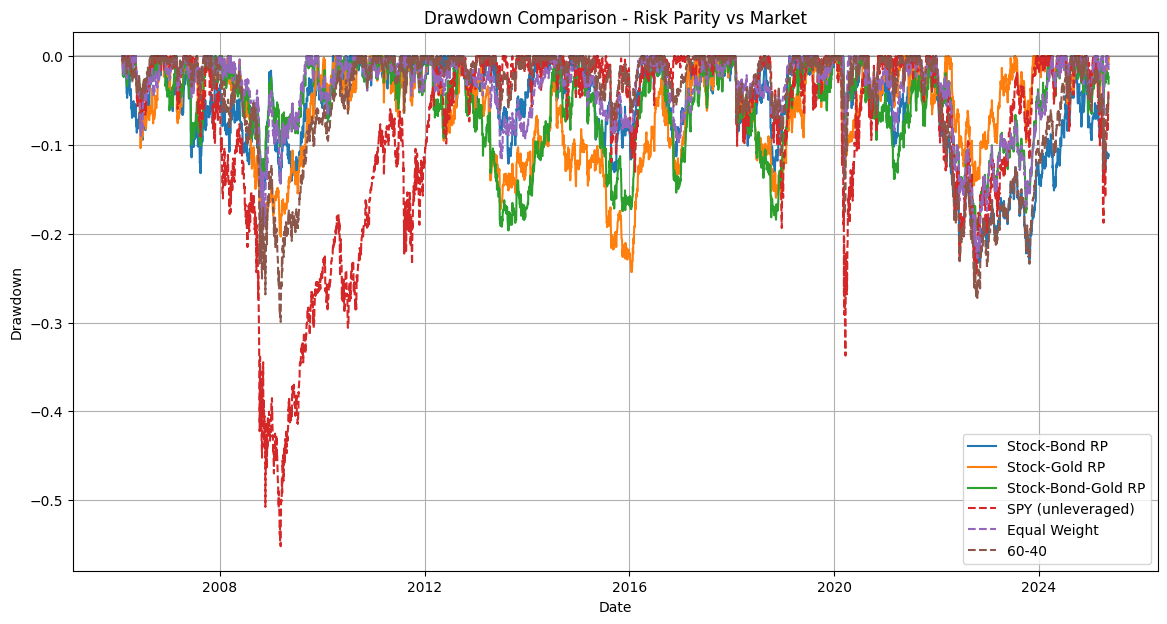

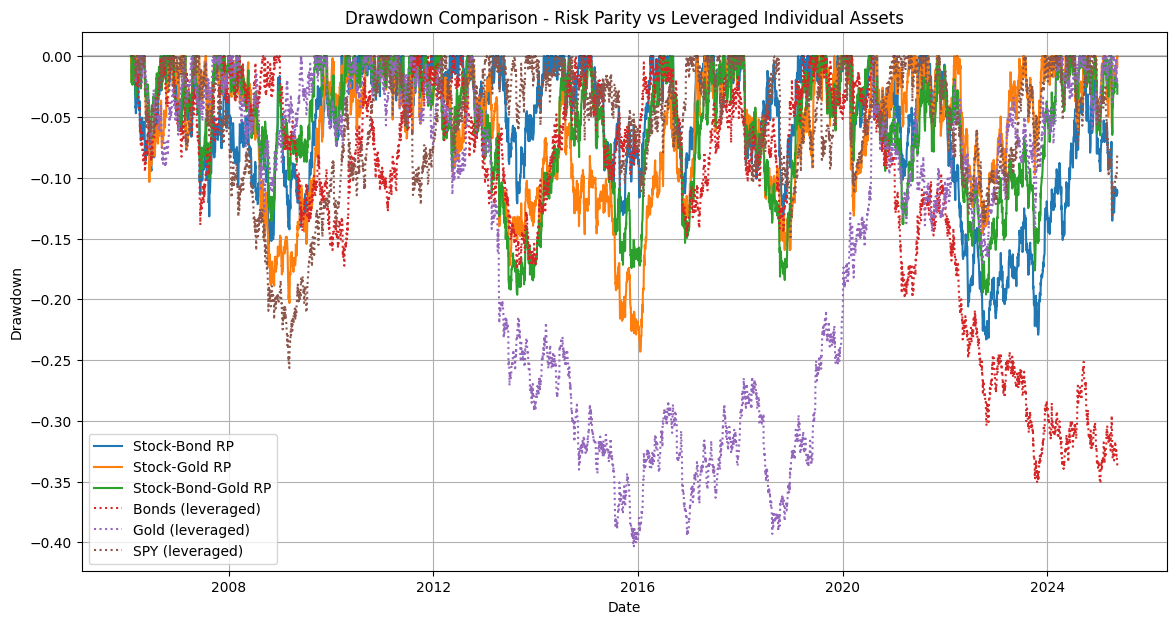

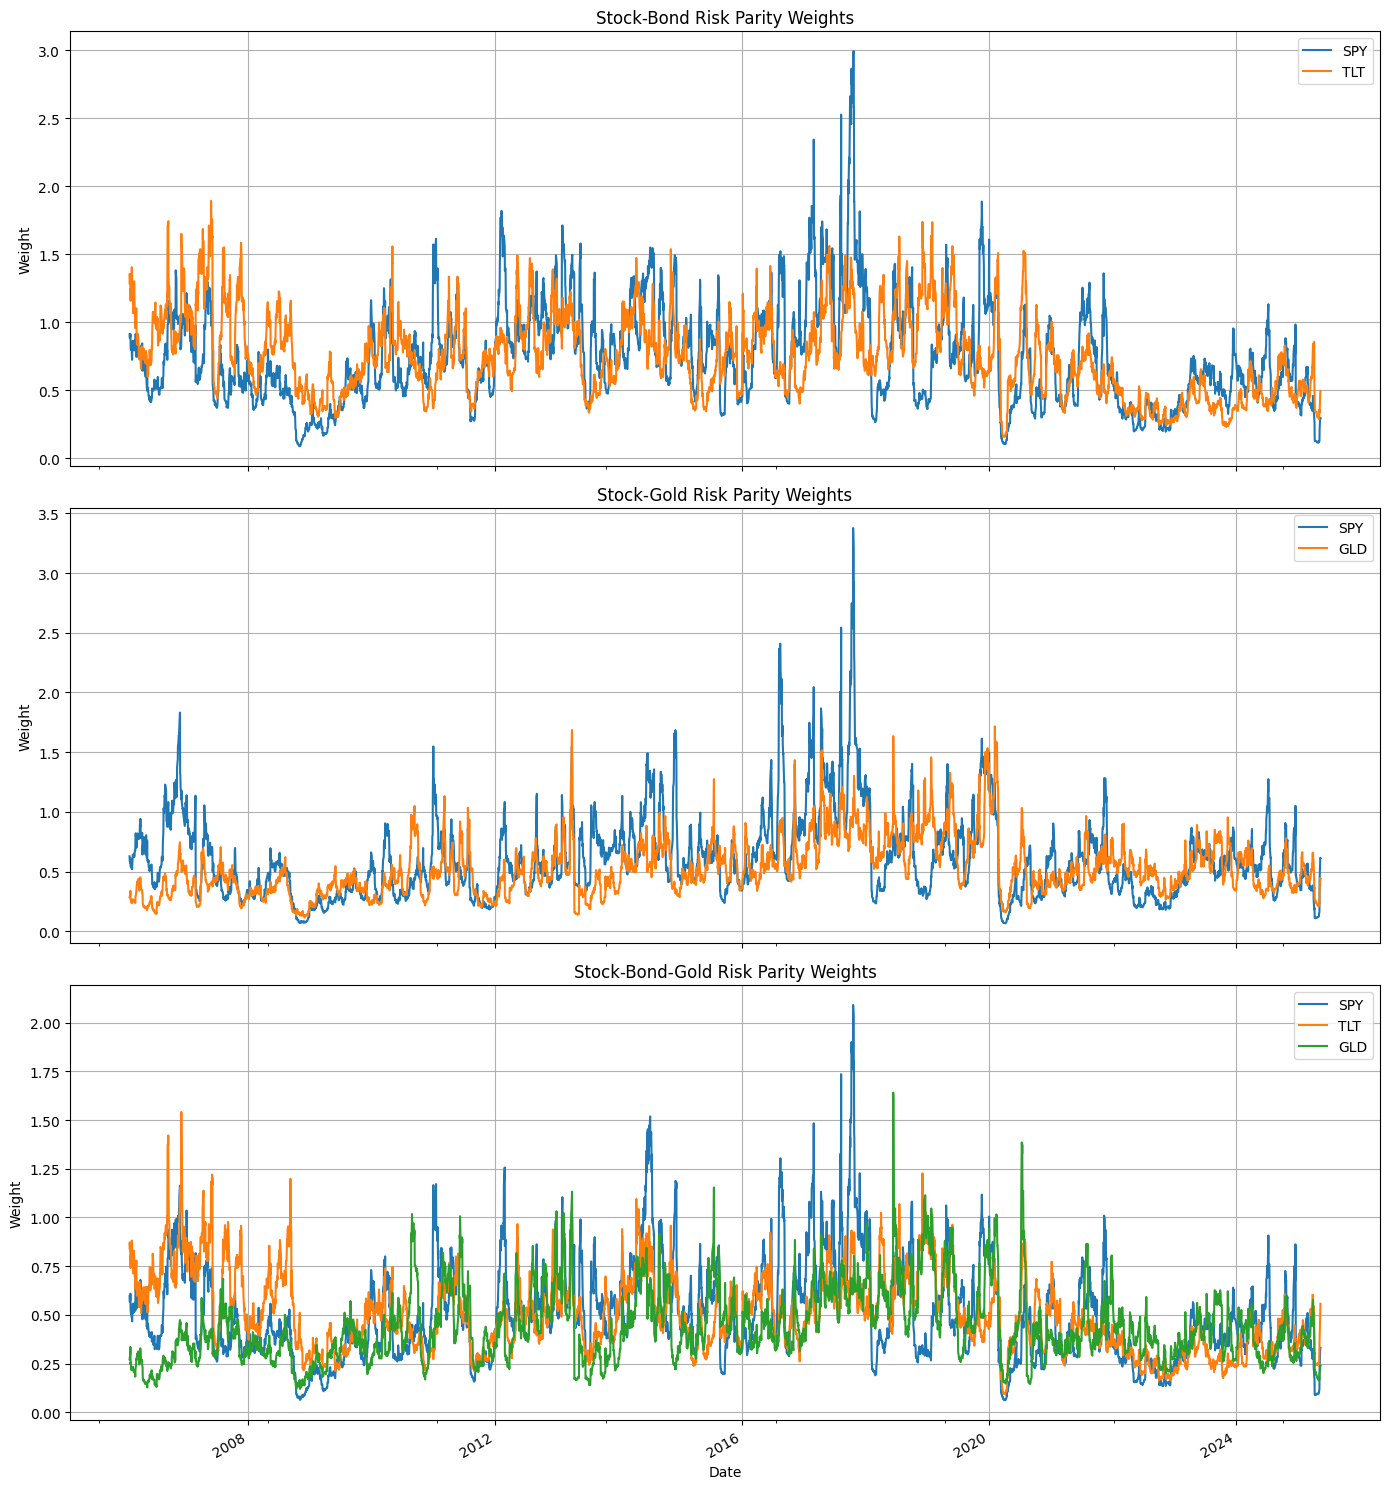

<Figure size 1400x500 with 0 Axes>

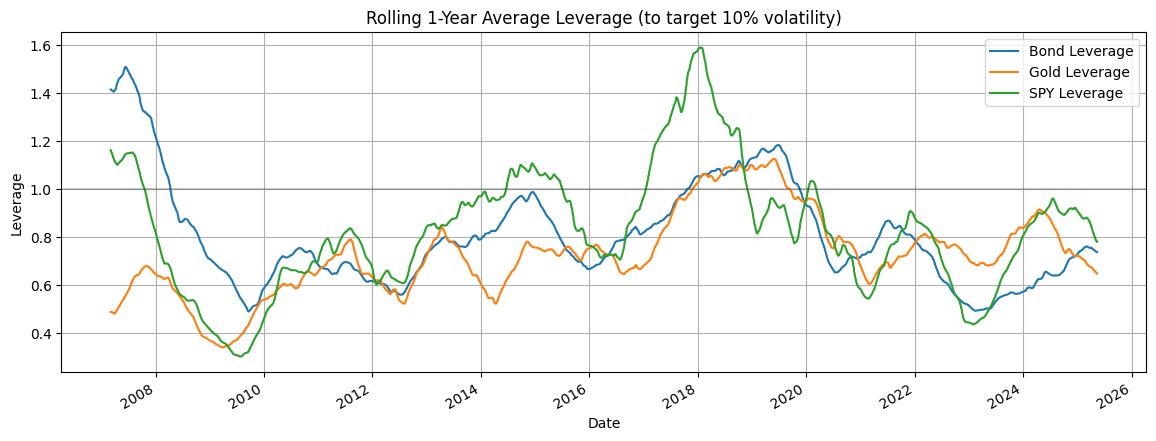

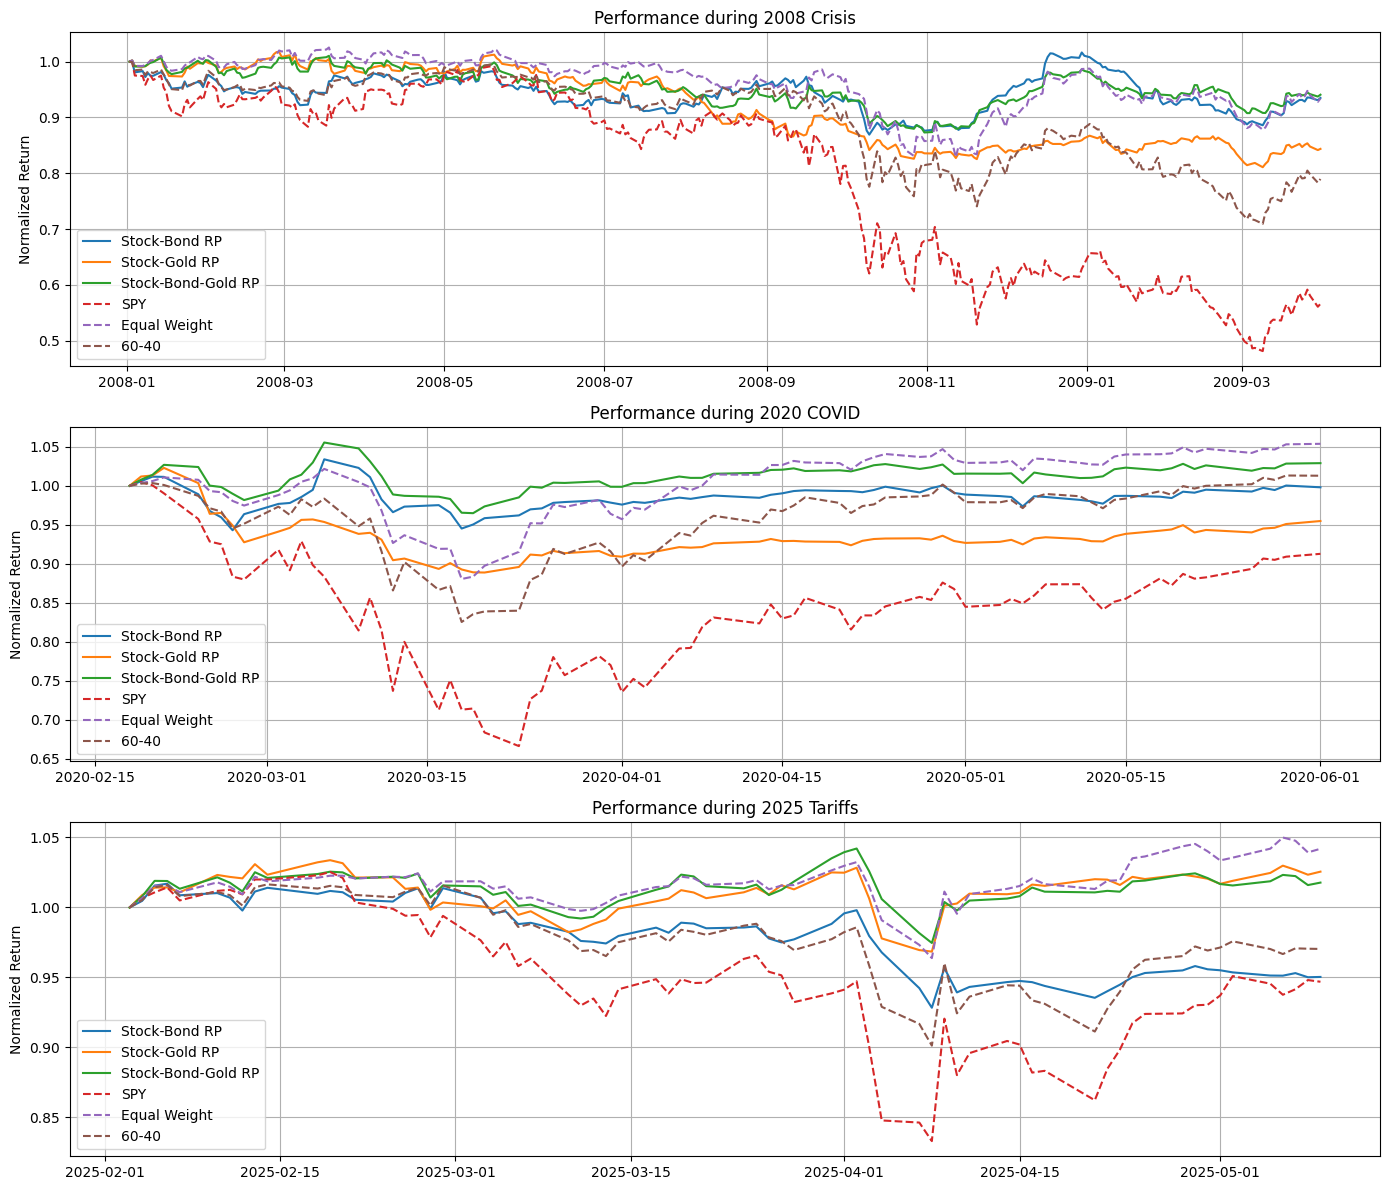

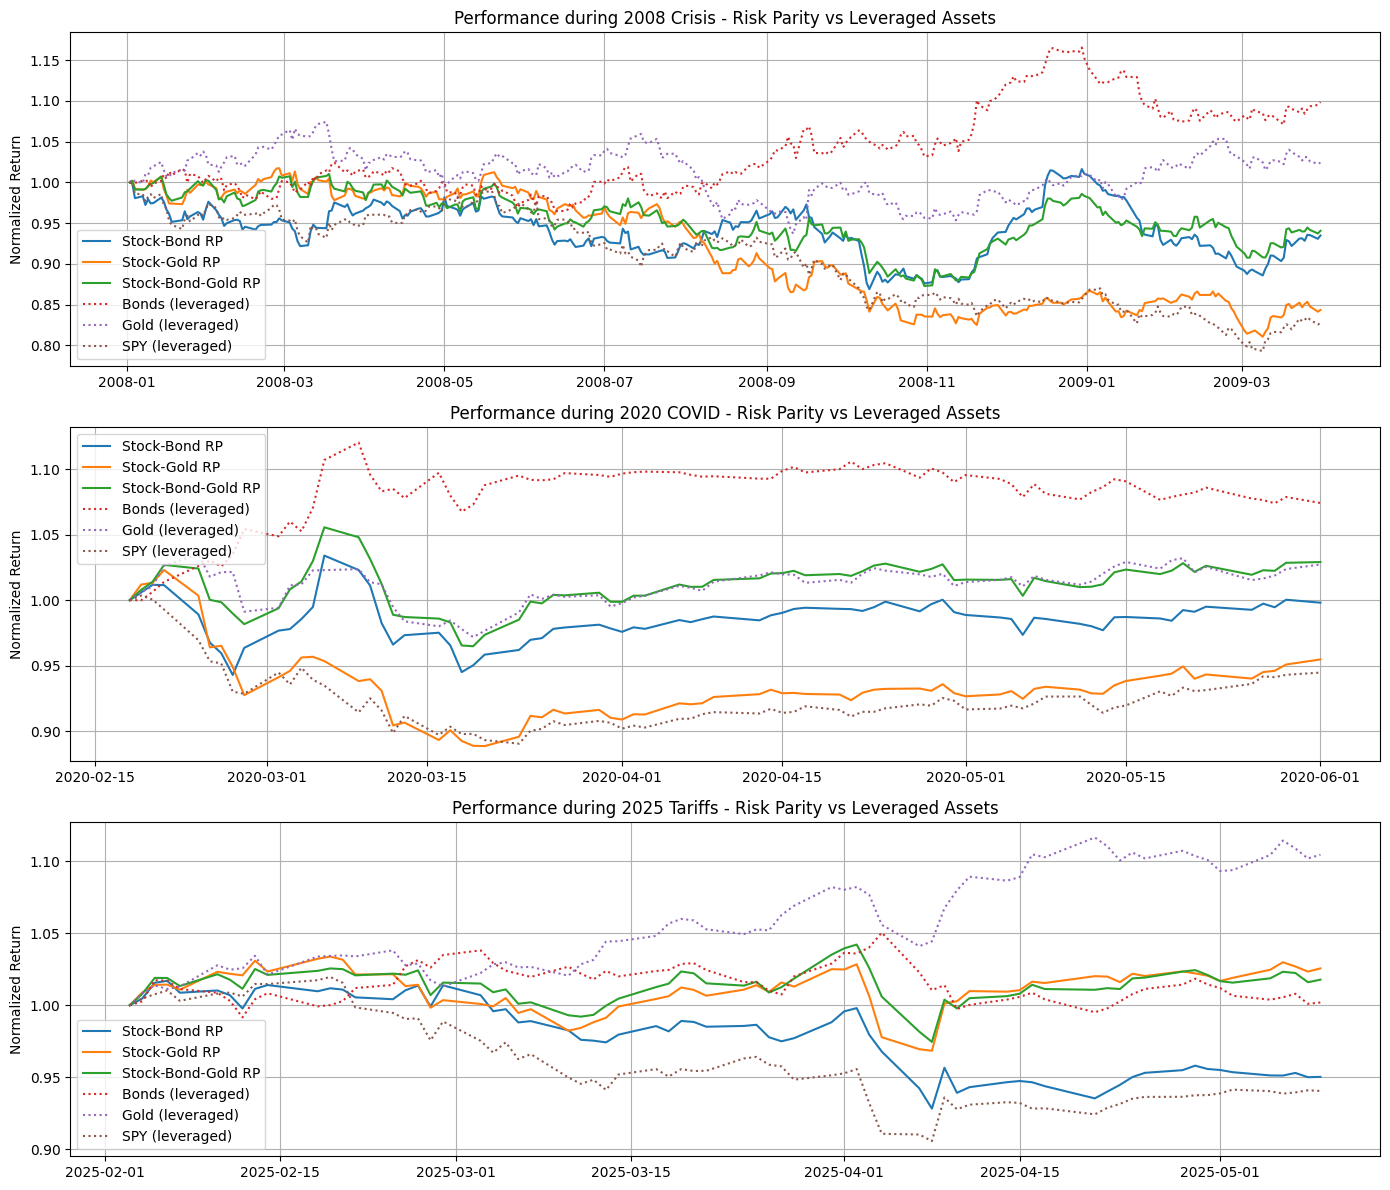

<Figure size 1600x800 with 0 Axes>

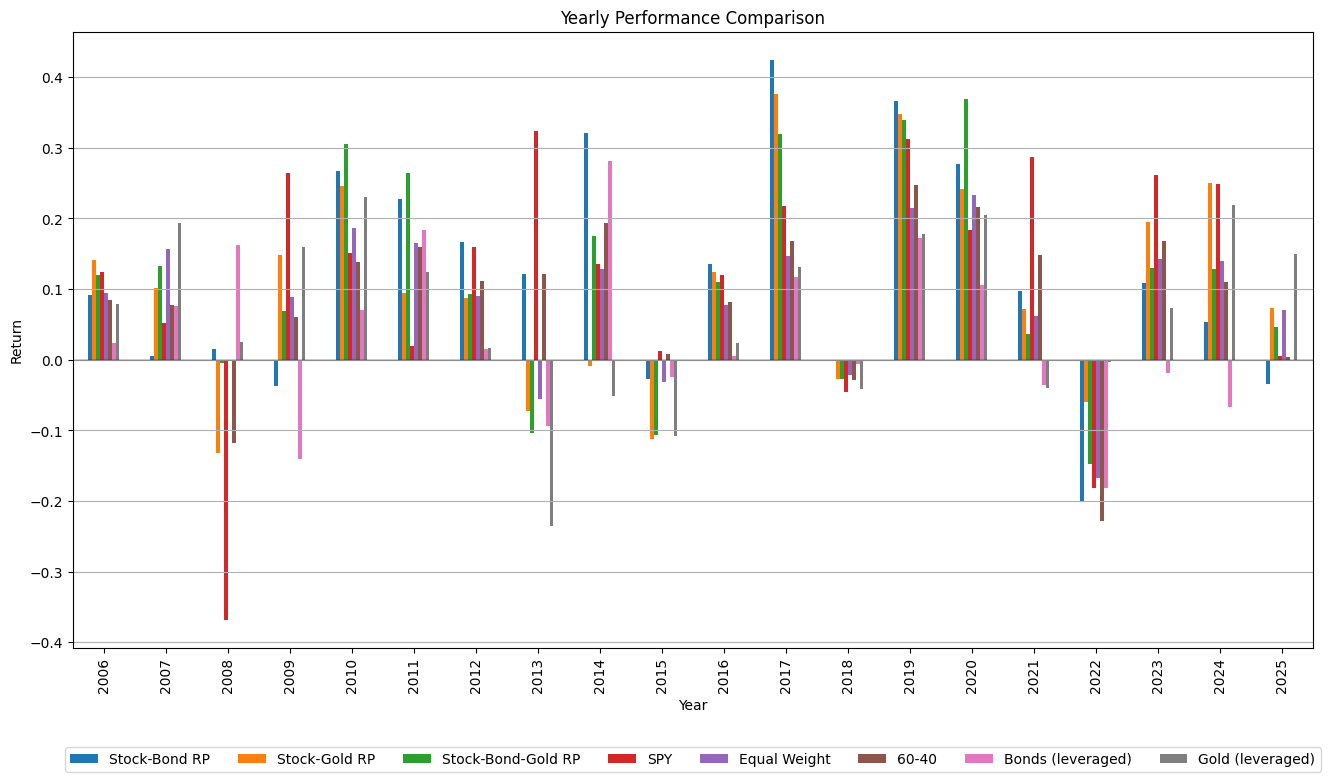

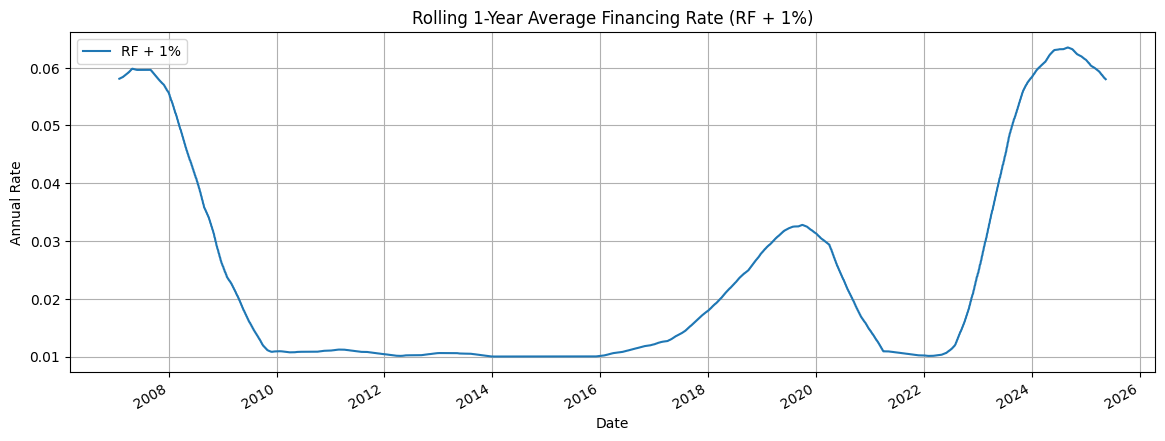

<Figure size 1600x800 with 0 Axes>

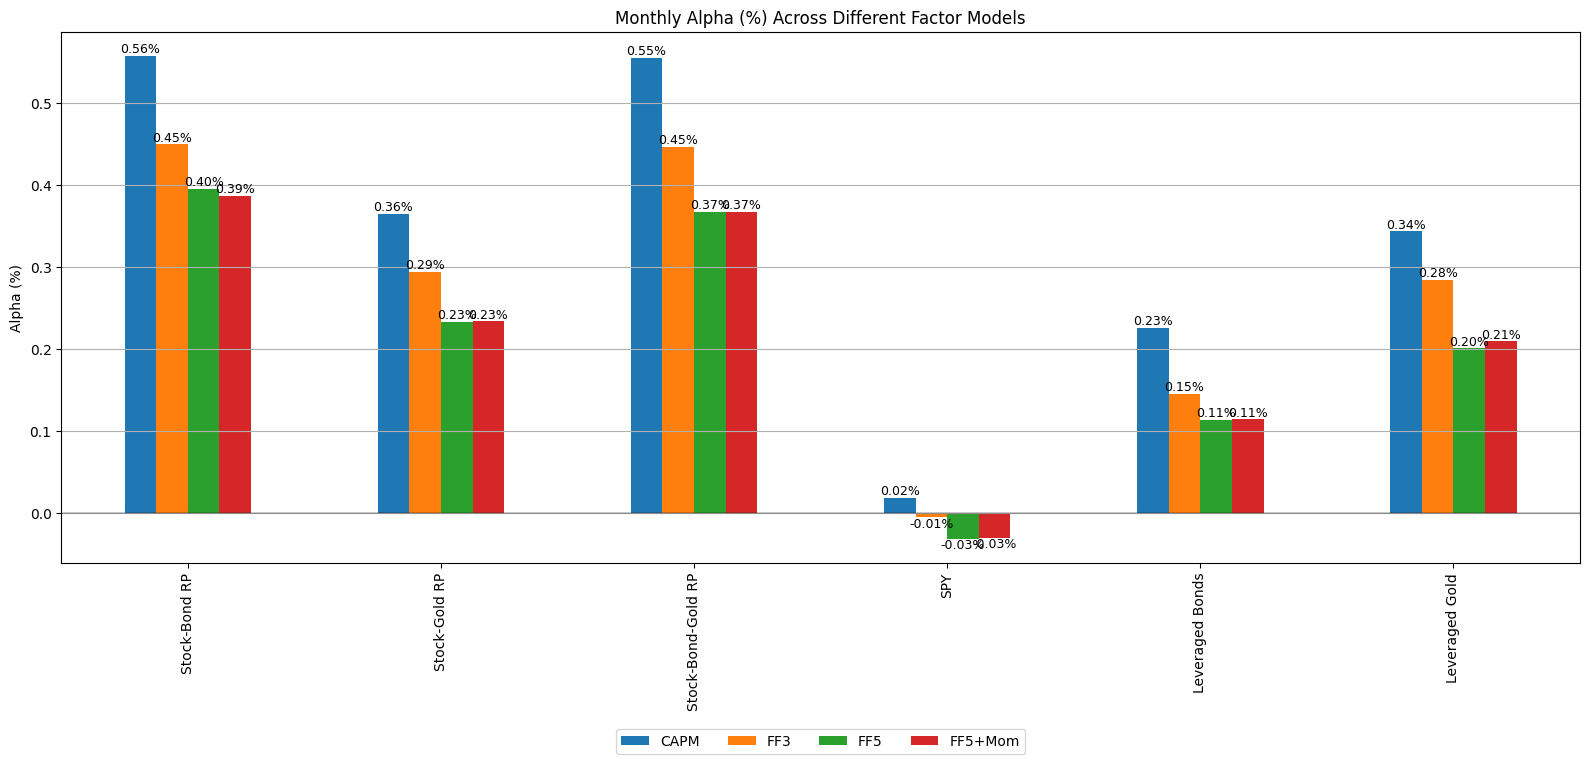

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

crisis_periods = {
    "2008 Crisis": ("2008-01-01", "2009-03-31"),
    "2020 COVID": ("2020-02-15", "2020-06-01"),
    "2025 Tariffs": ("2025-02-01", "2025-05-09")
}

WINDOW_SIZE = 60

# Function to load saved price data
def load_data(filename="data/price_data.csv"):
    """
    Load price data from CSV and convert to returns
    """
    data = pd.read_csv(filename, index_col=0, parse_dates=True)
    # Calculate returns
    returns = data.pct_change().dropna()
    return returns

# Function to calculate volatility
def calculate_volatility(returns, window):
    """
    Calculate rolling volatility of returns
    window: number of trading days for volatility calculation (default: 60 days)
    """
    return returns.rolling(window=window).std() * np.sqrt(252)  # Annualized

# Function to create risk parity portfolio weights
def risk_parity_weights(returns, vol_target, window):
    """
    Calculate risk parity weights using the full covariance matrix.
    vol_target: target annualized vol (default 10%)
    window: look-back window in trading days
    """
    # 1) compute marginal vols & inverse‐vol weights
    vols = calculate_volatility(returns, window=window)
    inv_vols = 1 / vols
    base_w = inv_vols.div(inv_vols.sum(axis=1), axis=0)

    # 2) for each date, slice out the last `window` returns, compute Σ_t and true σ_p
    true_vol = []
    for dt in base_w.index:
        w = base_w.loc[dt].values
        # grab the window of returns ending at dt
        windowed = returns.loc[:dt].iloc[-window:]
        Σ_t = windowed.cov() * 252            # annualized covariance matrix
        true_vol.append(np.sqrt(w @ Σ_t.values @ w))

    portfolio_vol = pd.Series(true_vol, index=base_w.index)

    # 3) scale to vol_target
    leverage = vol_target / portfolio_vol
    scaled_w = base_w.multiply(leverage, axis=0)

    # 4) shift to avoid look-ahead bias
    return scaled_w.shift(1).dropna()

# Function to load RF rates from Fama-French data
def load_rf_rates():
    """
    Load the risk-free rates from Fama-French data
    """
    ff3 = pd.read_csv("data/F-F_Research_Data_Factors.CSV")
    ff3 = ff3.rename(columns=lambda x: x.strip())
    ff3.rename(columns={ff3.columns[0]:'date'}, inplace=True)
    ff3['date'] = ff3['date'].astype(str)
    ff3['RF'] = pd.to_numeric(ff3['RF'], errors='coerce')
    
    # Convert YYYYMM to datetime
    ff3['datetime'] = pd.to_datetime(ff3['date'], format='%Y%m')
    
    # Set datetime as index
    ff3.set_index('datetime', inplace=True)
    
    # Convert monthly RF to daily by dividing by ~21 trading days
    # and convert from percentage to decimal if needed
    if ff3['RF'].mean() > 0.1:  # If mean is > 0.1, it's likely in percent
        daily_rf = ff3['RF'] / 100 / 21
    else:
        daily_rf = ff3['RF'] / 21
    
    # Resample to daily frequency, forward fill
    daily_rf = daily_rf.resample('D').ffill()
    
    return daily_rf

# Modified function to calculate portfolio returns with dynamic financing rate
def calculate_portfolio_returns(returns, weights, rf_rates=None, spread=0.01):
    """
    Calculate portfolio returns including financing costs for leverage
    
    Parameters:
    -----------
    returns : pd.DataFrame
        Asset returns
    weights : pd.DataFrame
        Portfolio weights (can include leverage)
    rf_rates : pd.Series
        Daily risk-free rates (if None, uses fixed 3% rate)
    spread : float
        Spread over RF rate (default 0.01 for 1%)
    """
    # Calculate gross portfolio returns
    gross_portfolio_returns = (returns * weights).sum(axis=1)
    
    # Calculate leverage at each point (sum of absolute weights)
    leverage = weights.abs().sum(axis=1)
    
    if rf_rates is not None:
        # Align RF rates with portfolio returns index
        aligned_rf = rf_rates.reindex(gross_portfolio_returns.index, method='ffill')
        
        # Daily financing rate = RF + spread (already in daily terms)
        daily_financing_rate = aligned_rf + spread/252  # Convert annual spread to daily
    else:
        # Fallback to fixed rate if RF not provided
        annual_financing_rate = 0.03
        daily_financing_rate = (1 + annual_financing_rate) ** (1/252) - 1
    
    # Financing cost applies to (leverage - 1) since the first 1x is unleveraged
    financing_cost = (leverage - 1).clip(lower=0) * daily_financing_rate
    
    # Net returns after financing costs
    net_portfolio_returns = gross_portfolio_returns - financing_cost
    
    return net_portfolio_returns

# Function to evaluate strategy performance
def evaluate_strategy(returns, name="Strategy"):
    """
    Calculate performance metrics for a strategy
    """
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol != 0 else 0
    
    # Calculate maximum drawdown
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    max_drawdown = drawdown.min()
    
    crisis_performance = {}
    for crisis_name, (start, end) in crisis_periods.items():
        try:
            crisis_returns = returns.loc[start:end]
            if not crisis_returns.empty:
                crisis_cumulative = (1 + crisis_returns).prod() - 1
                crisis_performance[crisis_name] = crisis_cumulative
            else:
                crisis_performance[crisis_name] = np.nan
        except:
            crisis_performance[crisis_name] = np.nan
    
    metrics = {
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Maximum Drawdown": max_drawdown,
        **crisis_performance
    }
    
    return pd.Series(metrics, name=name)

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def load_ff_factors():
    """
    Load the Fama-French three-factor data.
    Expected columns: date (in YYYYMM format), Mkt-RF, SMB, HML, RF.
    """
    ff3 = pd.read_csv("data/F-F_Research_Data_Factors.CSV")
    ff3 = ff3.rename(columns=lambda x: x.strip())
    # Rename the date column and keep as yearmonth format (e.g. 198601)
    ff3.rename(columns={ff3.columns[0]:'date'}, inplace=True)
    ff3['date'] = ff3['date'].astype(str)
    ff3[['Mkt-RF','SMB','HML','RF']] = ff3[['Mkt-RF','SMB','HML','RF']].apply(pd.to_numeric, errors='coerce')
    return ff3

def load_ff5_factors():
    """
    Load the Fama-French five-factor data.
    Expected columns: date, Mkt-RF, SMB, HML, RMW, CMA, RF.
    """
    ff5 = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv")
    ff5 = ff5.rename(columns=lambda x: x.strip())
    ff5.rename(columns={ff5.columns[0]:'date'}, inplace=True)
    ff5['date'] = ff5['date'].astype(str)
    ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']] = ff5[['Mkt-RF','SMB','HML','RMW','CMA','RF']].apply(pd.to_numeric, errors='coerce')
    return ff5

def load_momentum_factor():
    """
    Load the momentum factor data.
    Expected columns: date (in YYYYMM format), Mom.
    """
    mom = pd.read_csv("data/F-F_Momentum_Factor.CSV")
    mom = mom.rename(columns=lambda x: x.strip())
    mom.rename(columns={mom.columns[0]:'date'}, inplace=True)
    mom['date'] = mom['date'].astype(str)
    mom[['Mom']] = mom[['Mom']].apply(pd.to_numeric, errors='coerce')
    return mom

def run_regression(portfolio_returns, factor_data, model_type="CAPM", portfolio_name="Portfolio"):
    """
    Run asset pricing regressions using portfolio returns and factor data.
    
    Parameters:
    -----------
    portfolio_returns : pd.Series
        Portfolio returns with datetime index
    factor_data : pd.DataFrame
        Factor data containing Mkt-RF, SMB, HML, etc.
    model_type : str
        One of "CAPM", "FF3", "FF5", or "FF5+Momentum"
    portfolio_name : str
        Name of portfolio for output labeling
    """
    # Create DataFrame with portfolio returns and align with factor data
    df = pd.DataFrame({'ret': portfolio_returns})
    
    # Reset index and handle column name properly
    df = df.reset_index()
    
    # The reset index column could be named either 'index' or 'date' depending on the original index
    index_col = df.columns[0]  # Get the actual name of the first column
    
    # Convert datetime index to YYYYMM format to match FF data
    df['date'] = df[index_col].dt.strftime('%Y%m')
    
    # Drop the original datetime column
    df = df.drop(index_col, axis=1)
    
    # Merge portfolio returns with factors
    df = pd.merge(df, factor_data, on='date', how='inner')
    
    # Calculate excess returns
    # Check if FF data is in percent or decimal form
    if df['RF'].mean() > 0.1:  # If mean is > 0.1, it's likely in percent
        df['excess_ret'] = df['ret'] - df['RF'] / 100
    else:
        df['excess_ret'] = df['ret'] - df['RF']
    
    if model_type == "CAPM":
        X = sm.add_constant(df[['Mkt-RF']])
        model = sm.OLS(df['excess_ret'], X).fit()
        print(f"\n{portfolio_name} CAPM Regression Results:")
        print(model.summary().tables[1])
        
    elif model_type == "FF3":
        X = sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']])
        model = sm.OLS(df['excess_ret'], X).fit()
        print(f"\n{portfolio_name} FF3 Regression Results:")
        print(model.summary().tables[1])
        
    elif model_type == "FF5":
        X = sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
        model = sm.OLS(df['excess_ret'], X).fit()
        print(f"\n{portfolio_name} FF5 Regression Results:")
        print(model.summary().tables[1])
        
    elif model_type == "FF5+Momentum":
        # Add momentum factor
        df = pd.merge(df, mom, on='date', how='inner')
        
        X = sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']])
        model = sm.OLS(df['excess_ret'], X).fit()
        print(f"\n{portfolio_name} FF5+Momentum Regression Results:")
        print(model.summary().tables[1])
    
    return model

def convert_to_monthly(daily_returns):
    """
    Convert daily returns to monthly returns
    """
    return daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

def run_risk_parity_comparison(filename="data/price_data.csv", vol_target=0.10):
    """
    Run and compare risk parity strategies with different asset combinations,
    along with leveraged individual assets targeting the same volatility
    """
    # Load data
    all_data = load_data(filename)
    
    # Load RF rates for dynamic financing cost
    rf_rates = load_rf_rates()
    
    # Extract relevant columns for each strategy
    stock_bond_data = all_data[['SPY', 'TLT']]
    stock_gold_data = all_data[['SPY', 'GLD']]
    stock_bond_gold_data = all_data[['SPY', 'TLT', 'GLD']]  # Three-asset combination
    
    # Calculate risk parity weights
    stock_bond_weights = risk_parity_weights(stock_bond_data, vol_target=vol_target, window=WINDOW_SIZE)
    stock_gold_weights = risk_parity_weights(stock_gold_data, vol_target=vol_target, window=WINDOW_SIZE)
    stock_bond_gold_weights = risk_parity_weights(stock_bond_gold_data, vol_target=vol_target, window=WINDOW_SIZE)
    
    # Calculate portfolio returns with dynamic financing cost
    stock_bond_returns = calculate_portfolio_returns(
        stock_bond_data.loc[stock_bond_weights.index], 
        stock_bond_weights,
        rf_rates=rf_rates,
        spread=0.01
    )
    stock_gold_returns = calculate_portfolio_returns(
        stock_gold_data.loc[stock_gold_weights.index], 
        stock_gold_weights,
        rf_rates=rf_rates,
        spread=0.01
    )
    stock_bond_gold_returns = calculate_portfolio_returns(
        stock_bond_gold_data.loc[stock_bond_gold_weights.index], 
        stock_bond_gold_weights,
        rf_rates=rf_rates,
        spread=0.01
    )
    
    # Calculate individual asset volatilities for leverage
    # (Use the same window as for risk parity weights for consistency)
    window = WINDOW_SIZE
    
    # Get returns for individual assets (aligned with the same timeframe as the strategies)
    spy_returns = all_data['SPY'].loc[stock_bond_returns.index]
    bond_returns = all_data['TLT'].loc[stock_bond_returns.index]
    gold_returns = all_data['GLD'].loc[stock_bond_returns.index]
    
    # Calculate rolling volatilities
    spy_vol = calculate_volatility(spy_returns, window=window).shift(1)
    bond_vol = calculate_volatility(bond_returns, window=window).shift(1)
    gold_vol = calculate_volatility(gold_returns, window=window).shift(1)
    
    # Calculate leverage needed to target the same volatility
    spy_leverage = vol_target / spy_vol
    bond_leverage = vol_target / bond_vol
    gold_leverage = vol_target / gold_vol
    
    # Create DataFrames with leverage for individual assets
    spy_weights_df = pd.DataFrame({'SPY': spy_leverage}, index=spy_leverage.index)
    bond_weights_df = pd.DataFrame({'TLT': bond_leverage}, index=bond_leverage.index)
    gold_weights_df = pd.DataFrame({'GLD': gold_leverage}, index=gold_leverage.index)
    
    # Apply leverage to individual asset returns with dynamic financing
    leveraged_spy_returns = calculate_portfolio_returns(
        pd.DataFrame({'SPY': spy_returns}),
        spy_weights_df,
        rf_rates=rf_rates,
        spread=0.01
    )
    leveraged_bond_returns = calculate_portfolio_returns(
        pd.DataFrame({'TLT': bond_returns}),
        bond_weights_df,
        rf_rates=rf_rates,
        spread=0.01
    )
    leveraged_gold_returns = calculate_portfolio_returns(
        pd.DataFrame({'GLD': gold_returns}),
        gold_weights_df,
        rf_rates=rf_rates,
        spread=0.01
    )
    
    # Calculate returns for static portfolios
    # Equal weight portfolio (1/3 each)
    equal_weight_returns = (spy_returns + bond_returns + gold_returns) / 3
    
    # 60-40 portfolio
    sixty_forty_returns = 0.6 * spy_returns + 0.4 * bond_returns
    
    # Evaluate all strategies
    stock_bond_metrics = evaluate_strategy(stock_bond_returns, "Stock-Bond RP")
    stock_gold_metrics = evaluate_strategy(stock_gold_returns, "Stock-Gold RP")
    stock_bond_gold_metrics = evaluate_strategy(stock_bond_gold_returns, "Stock-Bond-Gold RP")
    spy_metrics = evaluate_strategy(spy_returns, "SPY (unleveraged)")
    leveraged_spy_metrics = evaluate_strategy(leveraged_spy_returns, "SPY (leveraged)")
    leveraged_bond_metrics = evaluate_strategy(leveraged_bond_returns, "Bonds (leveraged)")
    leveraged_gold_metrics = evaluate_strategy(leveraged_gold_returns, "Gold (leveraged)")
    equal_weight_metrics = evaluate_strategy(equal_weight_returns, "Equal Weight")
    sixty_forty_metrics = evaluate_strategy(sixty_forty_returns, "60-40")
    
    # Combine metrics
    all_metrics = pd.concat([
        stock_bond_metrics, 
        stock_gold_metrics,
        stock_bond_gold_metrics,  # Add three-asset metrics
        spy_metrics,
        leveraged_spy_metrics,
        leveraged_bond_metrics,
        leveraged_gold_metrics,
        equal_weight_metrics,
        sixty_forty_metrics
    ], axis=1)
    
    # Calculate cumulative returns for plotting
    stock_bond_cum = (1 + stock_bond_returns).cumprod()
    stock_gold_cum = (1 + stock_gold_returns).cumprod()
    stock_bond_gold_cum = (1 + stock_bond_gold_returns).cumprod()
    spy_cum = (1 + spy_returns).cumprod()
    leveraged_spy_cum = (1 + leveraged_spy_returns).cumprod()
    leveraged_bond_cum = (1 + leveraged_bond_returns).cumprod()
    leveraged_gold_cum = (1 + leveraged_gold_returns).cumprod()
    equal_weight_cum = (1 + equal_weight_returns).cumprod()
    sixty_forty_cum = (1 + sixty_forty_returns).cumprod()
    
    # Create comparative plots
    plt.figure(figsize=(14, 7))
    plt.plot(stock_bond_cum.index, stock_bond_cum, label='Stock-Bond RP')
    plt.plot(stock_gold_cum.index, stock_gold_cum, label='Stock-Gold RP')
    plt.plot(stock_bond_gold_cum.index, stock_bond_gold_cum, label='Stock-Bond-Gold RP')  # Add three-asset plot
    plt.plot(spy_cum.index, spy_cum, label='SPY (unleveraged)', linestyle='--')
    plt.plot(equal_weight_cum.index, equal_weight_cum, label='Equal Weight', linestyle='--')
    plt.plot(sixty_forty_cum.index, sixty_forty_cum, label='60-40', linestyle='--')
    plt.title(f'Cumulative Returns Comparison - Risk Parity vs Market (Vol Target: {vol_target*100}%)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    # Create comparative plots for leveraged individual assets
    plt.figure(figsize=(14, 7))
    plt.plot(stock_bond_cum.index, stock_bond_cum, label='Stock-Bond RP')
    plt.plot(stock_gold_cum.index, stock_gold_cum, label='Stock-Gold RP')
    plt.plot(stock_bond_gold_cum.index, stock_bond_gold_cum, label='Stock-Bond-Gold RP')  # Add three-asset plot
    plt.plot(leveraged_bond_cum.index, leveraged_bond_cum, label='Bonds (leveraged)', linestyle=':')
    plt.plot(leveraged_gold_cum.index, leveraged_gold_cum, label='Gold (leveraged)', linestyle=':')
    plt.plot(leveraged_spy_cum.index, leveraged_spy_cum, label='SPY (leveraged)', linestyle=':')
    plt.title(f'Cumulative Returns - Risk Parity vs Leveraged Individual Assets (Vol Target: {vol_target*100}%)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    
    # Add drawdown plot
    plt.figure(figsize=(14, 7))
    
    # Calculate drawdowns
    sb_drawdown = (stock_bond_cum / stock_bond_cum.cummax()) - 1
    sg_drawdown = (stock_gold_cum / stock_gold_cum.cummax()) - 1
    sbg_drawdown = (stock_bond_gold_cum / stock_bond_gold_cum.cummax()) - 1
    spy_drawdown = (spy_cum / spy_cum.cummax()) - 1
    lev_bond_drawdown = (leveraged_bond_cum / leveraged_bond_cum.cummax()) - 1
    lev_gold_drawdown = (leveraged_gold_cum / leveraged_gold_cum.cummax()) - 1
    lev_spy_drawdown = (leveraged_spy_cum / leveraged_spy_cum.cummax()) - 1
    equal_weight_drawdown = (equal_weight_cum / equal_weight_cum.cummax()) - 1
    sixty_forty_drawdown = (sixty_forty_cum / sixty_forty_cum.cummax()) - 1
    
    # Plot drawdowns - first chart with RP strategies and market
    plt.plot(sb_drawdown.index, sb_drawdown, label='Stock-Bond RP')
    plt.plot(sg_drawdown.index, sg_drawdown, label='Stock-Gold RP')
    plt.plot(sbg_drawdown.index, sbg_drawdown, label='Stock-Bond-Gold RP')  # Add three-asset drawdown
    plt.plot(spy_drawdown.index, spy_drawdown, label='SPY (unleveraged)', linestyle='--')
    plt.plot(equal_weight_drawdown.index, equal_weight_drawdown, label='Equal Weight', linestyle='--')
    plt.plot(sixty_forty_drawdown.index, sixty_forty_drawdown, label='60-40', linestyle='--')
    plt.title('Drawdown Comparison - Risk Parity vs Market')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Plot drawdowns - second chart with RP strategies and leveraged individual assets
    plt.figure(figsize=(14, 7))
    plt.plot(sb_drawdown.index, sb_drawdown, label='Stock-Bond RP')
    plt.plot(sg_drawdown.index, sg_drawdown, label='Stock-Gold RP')
    plt.plot(sbg_drawdown.index, sbg_drawdown, label='Stock-Bond-Gold RP')  # Add three-asset drawdown
    plt.plot(lev_bond_drawdown.index, lev_bond_drawdown, label='Bonds (leveraged)', linestyle=':')
    plt.plot(lev_gold_drawdown.index, lev_gold_drawdown, label='Gold (leveraged)', linestyle=':')
    plt.plot(lev_spy_drawdown.index, lev_spy_drawdown, label='SPY (leveraged)', linestyle=':')
    plt.title('Drawdown Comparison - Risk Parity vs Leveraged Individual Assets')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Plot weights over time
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)  # Added third subplot
    
    # Stock-Bond weights
    stock_bond_weights.plot(ax=axes[0], title='Stock-Bond Risk Parity Weights')
    axes[0].set_ylabel('Weight')
    axes[0].grid(True)
    axes[0].legend()
    
    # Stock-Gold weights
    stock_gold_weights.plot(ax=axes[1], title='Stock-Gold Risk Parity Weights')
    axes[1].set_ylabel('Weight')
    axes[1].grid(True)
    axes[1].legend()
    
    # Stock-Bond-Gold weights (new)
    stock_bond_gold_weights.plot(ax=axes[2], title='Stock-Bond-Gold Risk Parity Weights')
    axes[2].set_ylabel('Weight')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    
    # Plot average leverage for individual assets
    plt.figure(figsize=(14, 5))
    
    avg_leverage = pd.DataFrame({
        'Bond Leverage': bond_leverage,
        'Gold Leverage': gold_leverage,
        'SPY Leverage': spy_leverage
    })
    
    avg_leverage.rolling(window=252).mean().plot(figsize=(14, 5))
    plt.title('Rolling 1-Year Average Leverage (to target 10% volatility)')
    plt.xlabel('Date')
    plt.ylabel('Leverage')
    plt.grid(True)
    plt.axhline(y=1, color='black', linestyle='-', alpha=0.2)
    
    # Plot crisis performance with risk parity strategies
    fig, axes = plt.subplots(len(crisis_periods), 1, figsize=(14, 12), sharex=False)
    
    for i, (crisis_name, (start, end)) in enumerate(crisis_periods.items()):
        try:
            # Get data for the crisis period
            sb_crisis = stock_bond_cum.loc[start:end] / stock_bond_cum.loc[start:end].iloc[0]
            sg_crisis = stock_gold_cum.loc[start:end] / stock_gold_cum.loc[start:end].iloc[0]
            sbg_crisis = stock_bond_gold_cum.loc[start:end] / stock_bond_gold_cum.loc[start:end].iloc[0]
            spy_crisis = spy_cum.loc[start:end] / spy_cum.loc[start:end].iloc[0]
            equal_weight_crisis = equal_weight_cum.loc[start:end] / equal_weight_cum.loc[start:end].iloc[0]
            sixty_forty_crisis = sixty_forty_cum.loc[start:end] / sixty_forty_cum.loc[start:end].iloc[0]
            
            # Plot
            axes[i].plot(sb_crisis.index, sb_crisis, label='Stock-Bond RP')
            axes[i].plot(sg_crisis.index, sg_crisis, label='Stock-Gold RP')
            axes[i].plot(sbg_crisis.index, sbg_crisis, label='Stock-Bond-Gold RP')  # Add three-asset plot
            axes[i].plot(spy_crisis.index, spy_crisis, label='SPY', linestyle='--')
            axes[i].plot(equal_weight_crisis.index, equal_weight_crisis, label='Equal Weight', linestyle='--')
            axes[i].plot(sixty_forty_crisis.index, sixty_forty_crisis, label='60-40', linestyle='--')
            axes[i].set_title(f'Performance during {crisis_name}')
            axes[i].set_ylabel('Normalized Return')
            axes[i].grid(True)
            axes[i].legend()
        except:
            axes[i].text(0.5, 0.5, f'Not enough data for {crisis_name}', 
                         horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    
    # Plot crisis performance with leveraged individual assets
    fig, axes = plt.subplots(len(crisis_periods), 1, figsize=(14, 12), sharex=False)
    
    for i, (crisis_name, (start, end)) in enumerate(crisis_periods.items()):
        try:
            # Get data for the crisis period
            sb_crisis = stock_bond_cum.loc[start:end] / stock_bond_cum.loc[start:end].iloc[0]
            sg_crisis = stock_gold_cum.loc[start:end] / stock_gold_cum.loc[start:end].iloc[0]
            sbg_crisis = stock_bond_gold_cum.loc[start:end] / stock_bond_gold_cum.loc[start:end].iloc[0]
            lev_bond_crisis = leveraged_bond_cum.loc[start:end] / leveraged_bond_cum.loc[start:end].iloc[0]
            lev_gold_crisis = leveraged_gold_cum.loc[start:end] / leveraged_gold_cum.loc[start:end].iloc[0]
            lev_spy_crisis = leveraged_spy_cum.loc[start:end] / leveraged_spy_cum.loc[start:end].iloc[0]
            
            # Plot
            axes[i].plot(sb_crisis.index, sb_crisis, label='Stock-Bond RP')
            axes[i].plot(sg_crisis.index, sg_crisis, label='Stock-Gold RP')
            axes[i].plot(sbg_crisis.index, sbg_crisis, label='Stock-Bond-Gold RP')  # Add three-asset plot
            axes[i].plot(lev_bond_crisis.index, lev_bond_crisis, label='Bonds (leveraged)', linestyle=':')
            axes[i].plot(lev_gold_crisis.index, lev_gold_crisis, label='Gold (leveraged)', linestyle=':')
            axes[i].plot(lev_spy_crisis.index, lev_spy_crisis, label='SPY (leveraged)', linestyle=':')
            axes[i].set_title(f'Performance during {crisis_name} - Risk Parity vs Leveraged Assets')
            axes[i].set_ylabel('Normalized Return')
            axes[i].grid(True)
            axes[i].legend()
        except:
            axes[i].text(0.5, 0.5, f'Not enough data for {crisis_name}', 
                         horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    
    # Add yearly performance comparison
    yearly_returns = pd.DataFrame({
        'Stock-Bond RP': stock_bond_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'Stock-Gold RP': stock_gold_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'Stock-Bond-Gold RP': stock_bond_gold_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'SPY': spy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'Equal Weight': equal_weight_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        '60-40': sixty_forty_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'Bonds (leveraged)': leveraged_bond_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1),
        'Gold (leveraged)': leveraged_gold_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
    })

    yearly_returns.index = yearly_returns.index.year # convert index to years
    plt.figure(figsize=(16, 8))
    yearly_returns.plot(kind='bar', figsize=(16, 8))
    plt.title('Yearly Performance Comparison')
    plt.xlabel('Year')
    plt.ylabel('Return')
    plt.grid(True, axis='y')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    plt.legend(loc='upper center', ncol=8, bbox_to_anchor=(0.5, -0.15))

    # Plot RF + 1% financing rate over time
    plt.figure(figsize=(14, 5))
    aligned_rf = rf_rates.reindex(stock_bond_returns.index, method='ffill')
    financing_rate = (aligned_rf + 0.01/252) * 252  # Annualized for display
    financing_rate.rolling(window=252).mean().plot(label='RF + 1%')
    plt.title('Rolling 1-Year Average Financing Rate (RF + 1%)')
    plt.xlabel('Date')
    plt.ylabel('Annual Rate')
    plt.grid(True)
    plt.legend()
    
    return {
        'metrics': all_metrics,
        'stock_bond_returns': stock_bond_returns,
        'stock_gold_returns': stock_gold_returns,
        'stock_bond_gold_returns': stock_bond_gold_returns,
        'spy_returns': spy_returns,
        'leveraged_bond_returns': leveraged_bond_returns,
        'leveraged_gold_returns': leveraged_gold_returns,
        'leveraged_spy_returns': leveraged_spy_returns,
        'equal_weight_returns': equal_weight_returns,
        'sixty_forty_returns': sixty_forty_returns,
        'bond_leverage': bond_leverage,
        'gold_leverage': gold_leverage,
        'spy_leverage': spy_leverage,
        'yearly_returns': yearly_returns,
        'stock_bond_weights': stock_bond_weights,
        'stock_gold_weights': stock_gold_weights,
        'stock_bond_gold_weights': stock_bond_gold_weights,
        'rf_rates': aligned_rf,
        'financing_rate': financing_rate
    }


# Run the risk parity comparison
results = run_risk_parity_comparison(filename="data/price_data.csv", vol_target=0.10)

# Display results
print("\nPerformance Metrics:")
print(results['metrics'])

# Additional analysis: Correlation between strategies - now including Stock-Bond-Gold RP
correlation_sb_sg = results['stock_bond_returns'].corr(results['stock_gold_returns'])
correlation_sb_sbg = results['stock_bond_returns'].corr(results['stock_bond_gold_returns'])
correlation_sg_sbg = results['stock_gold_returns'].corr(results['stock_bond_gold_returns'])
correlation_sb_spy = results['stock_bond_returns'].corr(results['spy_returns'])
correlation_sg_spy = results['stock_gold_returns'].corr(results['spy_returns'])
correlation_sbg_spy = results['stock_bond_gold_returns'].corr(results['spy_returns'])

print(f"\nCorrelation Analysis:")
print(f"Stock-Bond RP vs Stock-Gold RP: {correlation_sb_sg:.4f}")
print(f"Stock-Bond RP vs Stock-Bond-Gold RP: {correlation_sb_sbg:.4f}")
print(f"Stock-Gold RP vs Stock-Bond-Gold RP: {correlation_sg_sbg:.4f}")
print(f"Stock-Bond RP vs SPY: {correlation_sb_spy:.4f}")
print(f"Stock-Gold RP vs SPY: {correlation_sg_spy:.4f}")
print(f"Stock-Bond-Gold RP vs SPY: {correlation_sbg_spy:.4f}")

# Use S&P 500 returns from our loaded data to define market regimes
spy_returns = results['spy_returns']
spy_ma200 = spy_returns.rolling(window=200).mean()
bull_market = spy_returns[spy_returns > spy_ma200].index
bear_market = spy_returns[spy_returns < spy_ma200].index

# Performance in bull markets - now including Stock-Bond-Gold RP
bull_sb = results['stock_bond_returns'].loc[bull_market].mean() * 252
bull_sg = results['stock_gold_returns'].loc[bull_market].mean() * 252
bull_sbg = results['stock_bond_gold_returns'].loc[bull_market].mean() * 252
bull_spy = results['spy_returns'].loc[bull_market].mean() * 252
bull_bond = results['leveraged_bond_returns'].loc[bull_market].mean() * 252
bull_gold = results['leveraged_gold_returns'].loc[bull_market].mean() * 252

# Performance in bear markets - now including Stock-Bond-Gold RP
bear_sb = results['stock_bond_returns'].loc[bear_market].mean() * 252
bear_sg = results['stock_gold_returns'].loc[bear_market].mean() * 252
bear_sbg = results['stock_bond_gold_returns'].loc[bear_market].mean() * 252
bear_spy = results['spy_returns'].loc[bear_market].mean() * 252
bear_bond = results['leveraged_bond_returns'].loc[bear_market].mean() * 252
bear_gold = results['leveraged_gold_returns'].loc[bear_market].mean() * 252

print("\nRegime Analysis - Performance in Different Market Conditions:")
print(f"Bull Market Performance:")
print(f"  Stock-Bond RP:      {bull_sb:.4f}")
print(f"  Stock-Gold RP:      {bull_sg:.4f}")
print(f"  Stock-Bond-Gold RP: {bull_sbg:.4f}")
print(f"  SPY:                {bull_spy:.4f}")
print(f"  Leveraged Bonds:    {bull_bond:.4f}")
print(f"  Leveraged Gold:     {bull_gold:.4f}")
print(f"Bear Market Performance:")
print(f"  Stock-Bond RP:      {bear_sb:.4f}")
print(f"  Stock-Gold RP:      {bear_sg:.4f}")
print(f"  Stock-Bond-Gold RP: {bear_sbg:.4f}")
print(f"  SPY:                {bear_spy:.4f}")
print(f"  Leveraged Bonds:    {bear_bond:.4f}")
print(f"  Leveraged Gold:     {bear_gold:.4f}")

# Create a summary table of crisis performance
crisis_performance = results['metrics'].loc[["2008 Crisis", "2020 COVID", "2025 Tariffs"]]
print("\nCrisis Performance Summary:")
print(crisis_performance)

# Load Fama-French factors
print("\nRunning Factor Regressions...")
ff3 = load_ff_factors()
ff5 = load_ff5_factors()
mom = load_momentum_factor()

# Convert daily returns to monthly - now including Stock-Bond-Gold RP
stock_bond_monthly = convert_to_monthly(results['stock_bond_returns'])
stock_gold_monthly = convert_to_monthly(results['stock_gold_returns'])
stock_bond_gold_monthly = convert_to_monthly(results['stock_bond_gold_returns'])
spy_monthly = convert_to_monthly(results['spy_returns'])
leveraged_bond_monthly = convert_to_monthly(results['leveraged_bond_returns'])
leveraged_gold_monthly = convert_to_monthly(results['leveraged_gold_returns'])

# Run CAPM regressions - now including Stock-Bond-Gold RP
print("\n----- CAPM Regressions -----")
sb_capm = run_regression(stock_bond_monthly, ff3, "CAPM", "Stock-Bond RP")
sg_capm = run_regression(stock_gold_monthly, ff3, "CAPM", "Stock-Gold RP")
sbg_capm = run_regression(stock_bond_gold_monthly, ff3, "CAPM", "Stock-Bond-Gold RP")
spy_capm = run_regression(spy_monthly, ff3, "CAPM", "SPY")
bond_capm = run_regression(leveraged_bond_monthly, ff3, "CAPM", "Leveraged Bonds")
gold_capm = run_regression(leveraged_gold_monthly, ff3, "CAPM", "Leveraged Gold")

# Run FF3 regressions - now including Stock-Bond-Gold RP
print("\n----- Fama-French 3-Factor Regressions -----")
sb_ff3 = run_regression(stock_bond_monthly, ff3, "FF3", "Stock-Bond RP")
sg_ff3 = run_regression(stock_gold_monthly, ff3, "FF3", "Stock-Gold RP")
sbg_ff3 = run_regression(stock_bond_gold_monthly, ff3, "FF3", "Stock-Bond-Gold RP")
spy_ff3 = run_regression(spy_monthly, ff3, "FF3", "SPY")
bond_ff3 = run_regression(leveraged_bond_monthly, ff3, "FF3", "Leveraged Bonds")
gold_ff3 = run_regression(leveraged_gold_monthly, ff3, "FF3", "Leveraged Gold")

# Run FF5 regressions - now including Stock-Bond-Gold RP
print("\n----- Fama-French 5-Factor Regressions -----")
sb_ff5 = run_regression(stock_bond_monthly, ff5, "FF5", "Stock-Bond RP")
sg_ff5 = run_regression(stock_gold_monthly, ff5, "FF5", "Stock-Gold RP")
sbg_ff5 = run_regression(stock_bond_gold_monthly, ff5, "FF5", "Stock-Bond-Gold RP")
spy_ff5 = run_regression(spy_monthly, ff5, "FF5", "SPY")
bond_ff5 = run_regression(leveraged_bond_monthly, ff5, "FF5", "Leveraged Bonds")
gold_ff5 = run_regression(leveraged_gold_monthly, ff5, "FF5", "Leveraged Gold")

# Run FF5+Momentum regressions - now including Stock-Bond-Gold RP
print("\n----- Fama-French 5-Factor + Momentum Regressions -----")
sb_ff5m = run_regression(stock_bond_monthly, ff5, "FF5+Momentum", "Stock-Bond RP")
sg_ff5m = run_regression(stock_gold_monthly, ff5, "FF5+Momentum", "Stock-Gold RP")
sbg_ff5m = run_regression(stock_bond_gold_monthly, ff5, "FF5+Momentum", "Stock-Bond-Gold RP")
spy_ff5m = run_regression(spy_monthly, ff5, "FF5+Momentum", "SPY")
bond_ff5m = run_regression(leveraged_bond_monthly, ff5, "FF5+Momentum", "Leveraged Bonds")
gold_ff5m = run_regression(leveraged_gold_monthly, ff5, "FF5+Momentum", "Leveraged Gold")

# Plot alphas across models for comparison - now including Stock-Bond-Gold RP
alphas = pd.DataFrame({
    'CAPM': [sb_capm.params['const'], sg_capm.params['const'], sbg_capm.params['const'],
             spy_capm.params['const'], bond_capm.params['const'], gold_capm.params['const']],
    'FF3': [sb_ff3.params['const'], sg_ff3.params['const'], sbg_ff3.params['const'],
            spy_ff3.params['const'], bond_ff3.params['const'], gold_ff3.params['const']],
    'FF5': [sb_ff5.params['const'], sg_ff5.params['const'], sbg_ff5.params['const'],
            spy_ff5.params['const'], bond_ff5.params['const'], gold_ff5.params['const']],
    'FF5+Mom': [sb_ff5m.params['const'], sg_ff5m.params['const'], sbg_ff5m.params['const'],
                spy_ff5m.params['const'], bond_ff5m.params['const'], gold_ff5m.params['const']]
}, index=['Stock-Bond RP', 'Stock-Gold RP', 'Stock-Bond-Gold RP', 
          'SPY', 'Leveraged Bonds', 'Leveraged Gold'])

# Convert to monthly percentage
alphas = alphas * 100

plt.figure(figsize=(16, 8))
ax = alphas.plot(kind='bar', figsize=(16, 8))
plt.title('Monthly Alpha (%) Across Different Factor Models')
plt.ylabel('Alpha (%)')
plt.grid(True, axis='y')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.3))

# Add value labels to the bars
for p in ax.patches:
    height = p.get_height()
    if height >= 0:
        ax.annotate(f'{height/100:.2%}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)
    else:
        ax.annotate(f'{height/100:.2%}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='top', fontsize=9)
plt.tight_layout()